In [1]:
from utils import plotcfg
from utils.ML2.utils import *

Matplotlib is building the font cache; this may take a moment.


# 4.0 Implementation

This chapter expands upon the findings from Section 3.3—where a recurrent architecture proved useful for modelling joint torques. The objective is to develop a single, integrated model that can function as a virtual force-torque sensor and estimate force torques even when multiple joints move simultaneously, an identified limitation in single-joint models. In addition, hyperparameter optimization is covered in this chapter to determine the best model and training parameters. The results are then discussed and contrasted with estimates based on motor current. Lastly, this chapter covers integration with the robot's software and real-time performance.

## 4.1 Data Collection

The robot was mounted horizontally with its base attached to a horizontal plane, as shown in Figure 3.2. Since the model needs to be trained on inputs from all joints, ensuring a good variance in the input signals from all joints was crucial, thereby exciting all dynamic parameters to achieve a robust model. To accomplish this, a method commonly used in previous studies [25,26] involves parameterizing the trajectory of each joint as a finite Fourier series:
\begin{equation}
q_i(t) = q_{i,0} + \sum_{k=1}^{N} \left( a_{i,k} \sin(k \omega_f t) + b_{i,k} \cos(k \omega_f t) \right),
\label{eq:4.1} \tag{4.1}
\end{equation}
where $t$ represents the time, $\omega_f$  is the fundamental frequency, $a _{i,k}$ and $b_{i,k}$ are the
amplitude of the sine and cosine functions and an offset $q_{i,0}$.

A genetic algorithm generated multiple collision-free trajectories. Due to space constraints, these trajectories were generated only within the following specific Cartesian coordinate limits:

* X-axis: [−0.2 m, 30 m]
* Y-axis: [−0.1 m, 1 m]
* Z-axis: [0 m, 60 m]

Loads were selected as follows and attached to the Tool Center Point (TCP):

* Cylindrical loads (Cog on Z axis): 0 kg, 1 kg, 2.45 kg, 3.70 kg, 4.95 kg, 6.2 kg
* Eccentric loads (Cog not on the Z axis): 1.74 kg, 2.95 kg, 4.57 kg, 5.46 kg

Three trajectories were randomly selected for each load, and a corresponding scaling factor was chosen from a uniform distribution ranging from 0.01 to 1 for each trajectory. Additionally, the eccentric loads were mounted in different orientations, with the center of gravity offset in various directions, to prevent overfitting to the tool's eccentricity or shape.

Data collection involved recording joint velocity, joint angle, torque feedforward, load-side encoder counts, and motor-side encoder counts for all six joints and force/torque sensor (FTS) readings at every 2 ms interval. This high-resolution data sampling ensured that detailed and accurate information was captured across various trajectories, loads, and varying velocity scalings.

## 4.2 Input and data preprocessing

Each step of the input sequence contains $\textit{joint velocity}, \textit{motor current}, \textit{torque feedforward}, \textit{motor side encoder count}, \textit{load side encoder count}$, and $\textit{encoder difference}$ from all six joints. As a result, each input sequence step contains $7 \times 6 = 42$ inputs, and the input tensor shape is $sequence\ length \times 42$. The sequence length is a hyperparameter that will be optimized in the next section. Since the data was sampled at 2 ms intervals, each neural network inference utilizes the latest data within a $sequence\ length \times 2\ ms$ time window as input.

Each of the seven types of input data is normalized to the range -1 to 1, as described in Section 3.2.2, which leads to good performance when using the $\textit{tanh}$ activation function[cite]. 

## 4.3 Hyper-parameter optimization

" Hyper-parameter refers to parameters that cannot be updated during the training of
machine learning. They can be involved in building the structure of the model, such as
the number of hidden layers and the activation function, or in determining the efficiency
and accuracy of model training, such as the learning rate. "[cite]
This section optimizes training parameters like the learning rate, number of epochs, and batch size, as well as structure-related parameters like sequence length, hidden size, and the number of layers.

The search space for each parameter is outlined in the table below:


Parameter          | Search Space
-------------------|----------------------------------------------------------
Learning Rate      | Log-uniform distribution between 1e-5 and 1e-1
Epochs             | Integer values between 1 and 50
Batch Size         | Categorical: 32, 64, 128, 256, 512, 1024, 2048, 4096
Sequence Length    | Integer values between 2 and 300
Hidden Size        | Integer values between 4 and 256
Number of Layers   | Integer values between 1 and 5

A library called  Optuna [cite] was employed to achieve efficient hyperparameter optimization. 
The study was designed to run 100 unique trials, with the goal of minimizing validation loss on a trajectory and load that were not part of the training dataset. The optimization process utilized TPESampler[cite], a form of Bayesian optimization that progressively refines the search space based on the history of previously suggested and evaluated parameters. 

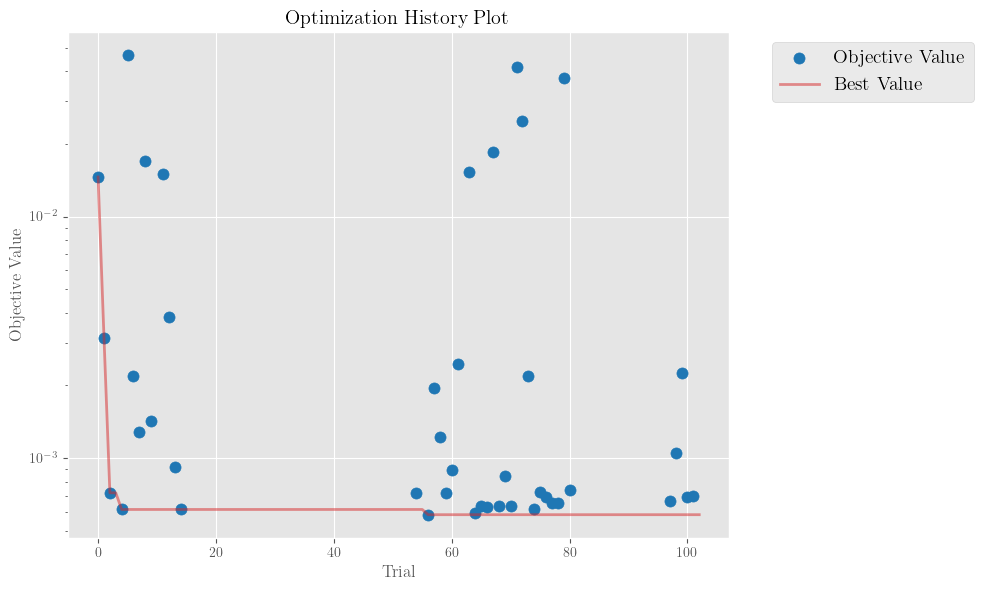

In [2]:
import optuna
import matplotlib.pyplot as plt
study = optuna.study.load_study(study_name = "study_20240702_134134",storage="sqlite:///utils/ML2/optuna_study.db");
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.yscale('log')
plt.tight_layout()

According to the study, the Best hyper parameters were found to be : 


In [3]:
learning_rate =  4.699241362945677e-05
EPOCHS = 50
BATCH_SIZE = 64
sequence_length = 116
hidden_size = 220 
num_layers = 5

## 4.4 Training

The training process remains unchanged from Section 3.4, so the code is not repeated here. Instead, a pretrained model is directly used in this chapter.

In [4]:
import os
import torch 

file_path = "utils/ML2/models/model.pt"
if os.path.exists(file_path):
    print("using pre-trained model")
    model = torch.jit.load('utils/ML2/models/model.pt', map_location=torch.device('cpu'))
else:
    print("model not found")

using pre-trained model


## 4.5 Results

To evaluate the model's performance and ensure it did not overfit the training data, a separate validation trajectory was generated according to the specifications outlined in Section 4.1. A different load of mass 
𝑥
x kg was attached during this validation, ensuring the model's ability to generalize across different loads. The evaluation of the model's predictions is presented below.

Figure 4.2 illustrates the model's prediction of the Wrench at the Tool Center Point (TCP) alongside the Force/Torque Sensor (FTS) readings. The close fit between these two indicates that the model effectively captures the dynamic coupling effects between different links. Figure 4.3 shows the model's predictions converted into joint space, using the formula provided in Equation (). For comparison, results from motor current-based methods are also plotted, highlighting the significant improvement offered by this approach.

100%|██████████| 70247/70247 [54:40<00:00, 21.41it/s]  


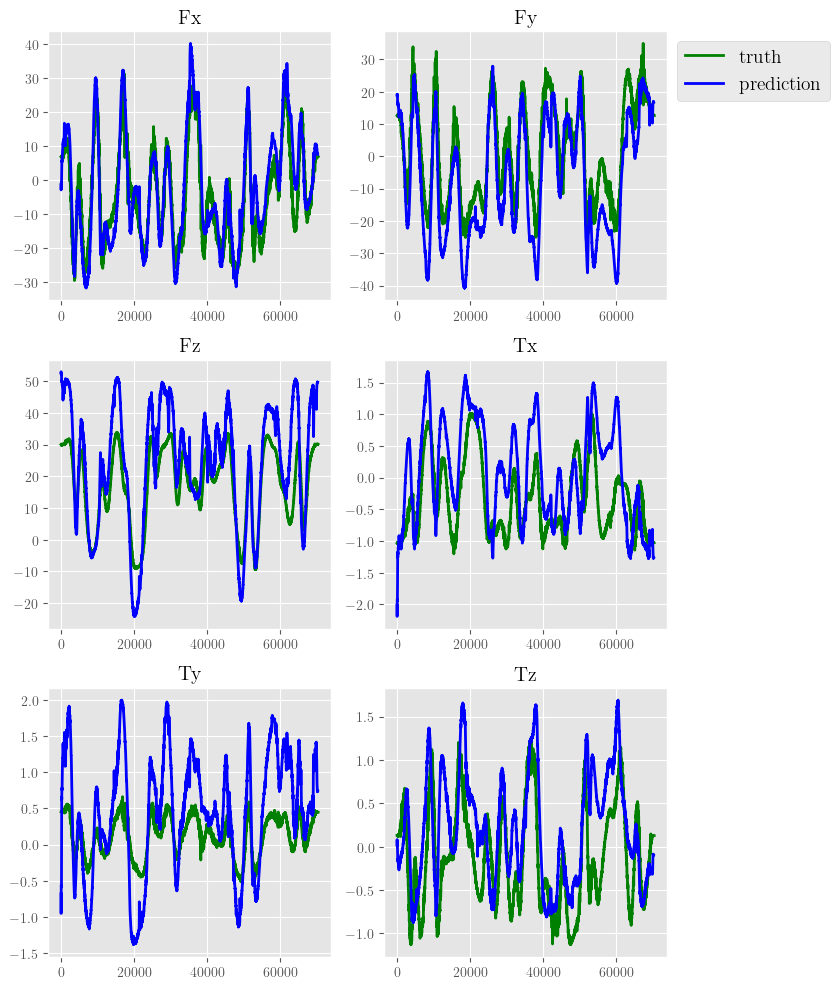

In [5]:
#to denormalize the predictions
y_max = torch.load('utils/ML2/models/y_max.pt',map_location=torch.device('cpu'))
y_min = torch.load('utils/ML2/models/y_min.pt',map_location=torch.device('cpu'))

dataset = CustomDatasetFromCSV(csv_path = 'utils/ML2/validation.csv', mode="test")
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

model.eval()

pred_list = []
with torch.no_grad():    
    for i, (X,y) in enumerate(tqdm(test_dataloader)):
        pred = model(X)
        #denormalize predictions
        pred = (pred+1)/2* (y_max - y_min) + y_min
        pred_list.append(pred)
#denormalize the data
y_truth = ((test_dataloader.dataset.y + 1)/2* (y_max - y_min) + y_min).cpu().numpy()
pred_list = torch.cat(pred_list).numpy()

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
# Plotting each component
components = ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']
for i, ax in enumerate(axes.flat):
    if i < y_truth.shape[1]: 
        ax.plot(y_truth[:, i], label="truth",color = "green")
        ax.plot(pred_list[:, i], label="prediction", color = "cyan")
        ax.set_title(components[i])
    else:
        ax.set_visible(False)
axes[0, 1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()

RMS Error between prediction and measured: [ 6.0573379  10.53062487  7.0291029   1.76660096  1.77846127  0.65449592]
RMS Error between calculated and measured: [ 9.90688797 14.83681179 10.17114894  3.4219677   2.77787533  0.99787841]


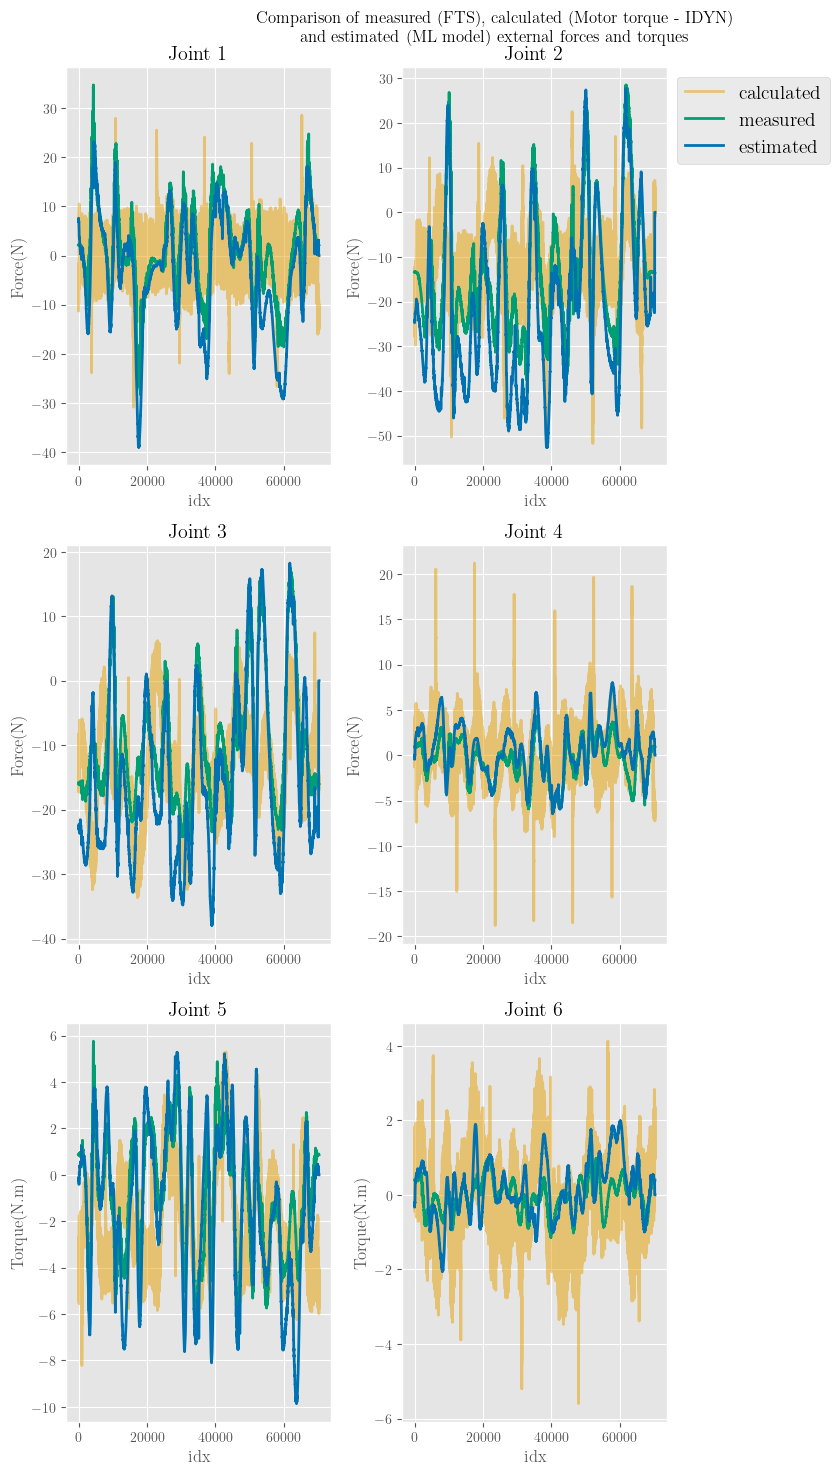

In [23]:

plot_joint_torques(pred_list)

The results demonstarate that the RMS error of ML based apprach is xxx and the error of motor current based method is xxx. this shows an improvement of  x% over the existing method.

## 4.6 Integration

To integrate the model into the robot software for real-time inference, it was essential that the average inference time be less than 2 ms. Given that the robot's software stack is written in C++, the model was saved in ONNX format, which supports efficient inference in C++. Upon testing, the inference time met the required threshold. The detailed results are summarized in the table below:
| **Metric**              | **Result**  |
|-------------------------|-------------|
| Average Inference Time  | 0.33 ms     |
| Minimum Inference Time  | 0.18 ms     |
| Maximum Inference Time  | 12.68 ms    |

The high maximum inference time could be due to other software components in the robot system executing with higher priority. This issue may be rectified by assigning a higher priority to the model during execution. Further testing is planned to address this in the future.